**[2024-2] CSC4023 Deep Learning (딥러닝입문)**

Exercise 01: Perceptron & Gradient Descent



# 1. Perceptron
---


#### 1-1. 라이브러리 다운로드

In [2]:
!pip -q install numpy matplotlib torch

In [3]:
import math
import random
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

#### 1-2. 시드 고정

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#### 1-3. 2D 데이터 생성 및 시각화


In [10]:
def make_linear_overlap(
    n_per_class=1000,
    mean=2,          
    std=2.5,           
    angle_deg=25.0,    
    flip_prob=0.05,   
    device="cpu",
    seed=42
):
    g = torch.Generator(device=device).manual_seed(seed)


    pos = torch.randn((n_per_class, 2), generator=g, device=device) * std + torch.tensor([ mean,  mean], device=device)
    neg = torch.randn((n_per_class, 2), generator=g, device=device) * std + torch.tensor([-mean, -mean], device=device)

    theta = math.radians(angle_deg)
    R = torch.tensor([[math.cos(theta), -math.sin(theta)],
                      [math.sin(theta),  math.cos(theta)]], device=device)
    neg = neg @ R.T

    X = torch.cat([pos, neg], dim=0)  
    y = torch.cat([torch.ones(n_per_class, device=device),
                   -torch.ones(n_per_class, device=device)], dim=0)

    if flip_prob > 0:
        flip_mask = torch.rand(X.size(0), generator=g, device=device) < flip_prob
        y = torch.where(flip_mask, -y, y)

    perm = torch.randperm(X.size(0), generator=g, device=device)
    X = X[perm]
    y = y[perm]
    return X, y

X, y = make_linear_overlap(
    n_per_class=1000,
    mean=5,      
    std=3.2,        
    angle_deg=25.0, 
    flip_prob=0.03  
)

print(X.shape, y.shape)

torch.Size([2000, 2]) torch.Size([2000])


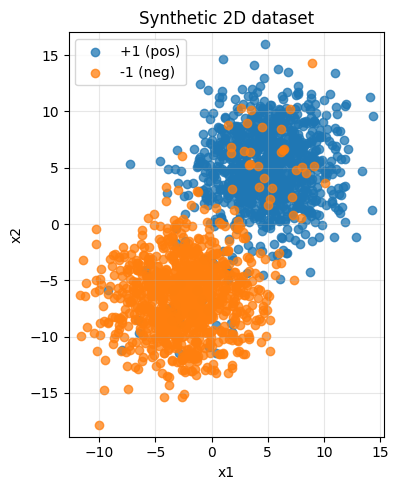

In [11]:
X_np = X.numpy()
y_np = y.numpy()

plt.figure(figsize=(6,5))
plt.scatter(X_np[y_np==1, 0], X_np[y_np==1, 1], label="+1 (pos)", alpha=0.75)
plt.scatter(X_np[y_np==-1, 0], X_np[y_np==-1, 1], label="-1 (neg)", alpha=0.75)

pad = 1.0
xmin, xmax = X_np[:,0].min()-pad, X_np[:,0].max()+pad
ymin, ymax = X_np[:,1].min()-pad, X_np[:,1].max()+pad
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, alpha=0.3)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Synthetic 2D dataset")
plt.legend()
plt.tight_layout()
plt.show()

#### 1-3 Perceptron 클래스 구현

In [12]:
class Perceptron(nn.Module):

    def __init__(self, in_dim: int, lr: float = 1.0):
        super().__init__()
        self.w = nn.Parameter(torch.zeros(in_dim), requires_grad=False)
        self.b = nn.Parameter(torch.zeros(1), requires_grad=False)
        self.lr = lr

    @torch.no_grad()
    def predict_raw(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.w + self.b

    @torch.no_grad()
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        raw = self.predict_raw(x)
        pos = torch.tensor(1.0, device=raw.device)
        neg = torch.tensor(-1.0, device=raw.device)
        return torch.where(raw >= 0, pos, neg)

    @torch.no_grad()
    def fit(self, x: torch.Tensor, y: torch.Tensor, max_epochs: int = 1000, shuffle: bool = True):
        n = x.size(0)
        mistakes_per_epoch = []

        for epoch in range(max_epochs):
            if shuffle:
                idx = torch.randperm(n)
                x_epoch = x[idx]
                y_epoch = y[idx]
            else:
                x_epoch = x
                y_epoch = y

            mistakes = 0
            for xi, yi in zip(x_epoch, y_epoch):
                score = (xi @ self.w + self.b).item()
                yi_val = yi.item()
                pred = 1.0 if score >= 0.0 else -1.0
                if pred != yi_val:
                    self.w[:] = self.w + self.lr * yi_val * xi
                    self.b[:] = self.b + self.lr * yi_val
                    mistakes += 1

            mistakes_per_epoch.append(mistakes)

        return mistakes_per_epoch

#### 1-4. 모델 생성 및 학습

In [14]:
model = Perceptron(in_dim=2, lr=1.0)

max_epochs = 200
history = model.fit(X, y, max_epochs=max_epochs, shuffle=True)

print("Learned w:", model.w.detach().cpu().numpy())
print("Learned b:", float(model.b.item()))


with torch.no_grad():
    pred = model.predict(X)
    acc = (pred.eq(y)).float().mean().item()
print(f"Train Accuracy: {acc*100:.2f}%")

Learned w: [6.959267  4.9567146]
Learned b: 3.0
Train Accuracy: 94.35%


#### 1-5. 시각화

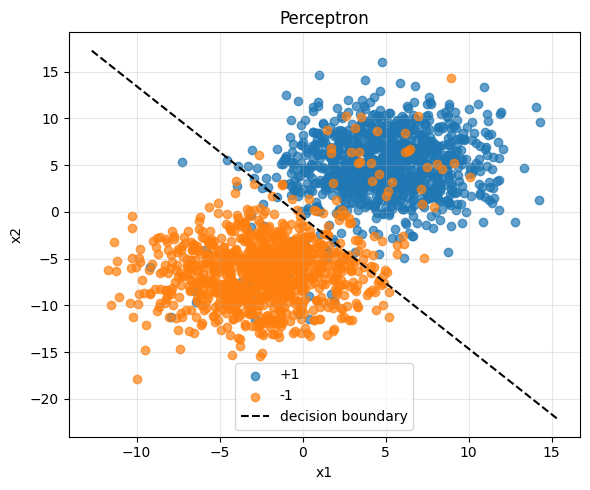

In [15]:

plt.figure(figsize=(6, 5))
X_np = X.numpy()
y_np = y.numpy()
plt.scatter(X_np[y_np==1, 0], X_np[y_np==1, 1], c='tab:blue', label='+1', alpha=0.7)
plt.scatter(X_np[y_np==-1, 0], X_np[y_np==-1, 1], c='tab:orange', label='-1', alpha=0.7)

w = model.w.detach().numpy()
b = model.b.item()
if abs(w[1]) > 1e-8:
    xs = np.linspace(X_np[:,0].min()-1, X_np[:,0].max()+1, 200)
    ys = -(w[0]/w[1]) * xs - b / w[1]
    plt.plot(xs, ys, 'k--', label='decision boundary')
else:
    x_line = -b / (w[0] + 1e-12)
    plt.axvline(x_line, color='k', linestyle='--', label='decision boundary')

plt.title('Perceptron')
plt.xlabel('x1'); plt.ylabel('x2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Linear Regression & Gradient Descent
---

#### 2.1 데이터 셋 확인 및 시각화

torch.Size([2000, 2]) torch.Size([2000])


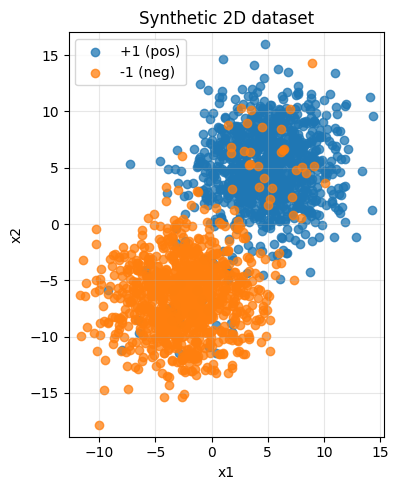

In [ ]:
def make_linear_overlap(
    n_per_class=1000,
    mean=2,          
    std=2.5,           
    angle_deg=25.0,    
    flip_prob=0.05,   
    device="cpu",
    seed=42
):
    g = torch.Generator(device=device).manual_seed(seed)

    pos = torch.randn((n_per_class, 2), generator=g, device=device) * std + torch.tensor([ mean,  mean], device=device)
    neg = torch.randn((n_per_class, 2), generator=g, device=device) * std + torch.tensor([-mean, -mean], device=device)

    theta = math.radians(angle_deg)
    R = torch.tensor([[math.cos(theta), -math.sin(theta)],
                      [math.sin(theta),  math.cos(theta)]], device=device)
    neg = neg @ R.T

    X = torch.cat([pos, neg], dim=0)  
    y = torch.cat([torch.ones(n_per_class, device=device),
                   -torch.ones(n_per_class, device=device)], dim=0)

    if flip_prob > 0:
        flip_mask = torch.rand(X.size(0), generator=g, device=device) < flip_prob
        y = torch.where(flip_mask, -y, y)

    perm = torch.randperm(X.size(0), generator=g, device=device)
    X = X[perm]
    y = y[perm]
    return X, y

device = "cpu"
X, y = make_linear_overlap(
    n_per_class=1000,
    mean=5,      
    std=3.2,        
    angle_deg=25.0, 
    flip_prob=0.03,
    device=device,
    seed=42
)
print(X.shape, y.shape) 

X_np = X.numpy()
y_np = y.numpy()

plt.figure(figsize=(6,5))
plt.scatter(X_np[y_np==1, 0], X_np[y_np==1, 1], label="+1 (pos)", alpha=0.75)
plt.scatter(X_np[y_np==-1, 0], X_np[y_np==-1, 1], label="-1 (neg)", alpha=0.75)

pad = 1.0
xmin, xmax = X_np[:,0].min()-pad, X_np[:,0].max()+pad
ymin, ymax = X_np[:,1].min()-pad, X_np[:,1].max()+pad
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, alpha=0.3)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Synthetic 2D dataset")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
N, D = X.shape 
w = torch.full((D,), -0.5, device=device)  
b = torch.tensor(0.0, device=device)

lr = 1e-3
epochs = 100

mse_history = []
wb_snapshots = {}  

for epoch in range(epochs + 1):
    y_hat = X @ w + b 
    mse = torch.mean((y_hat - y) ** 2)
    if epoch % 20 == 0:
        wb_snapshots[epoch] = (w.clone(), float(b))
        print(f"[epoch {epoch:3d}] MSE = {mse.item():.6f}")

    mse_history.append(float(mse))
    if epoch == epochs:
        break

    residual = (y_hat - y) 
    grad_w = (2.0 / N) * (X.T @ residual)   
    grad_b = (2.0 / N) * torch.sum(residual)

    w = w - lr * grad_w
    b = b - lr * grad_b

[epoch   0] MSE = 38.122108
[epoch  20] MSE = 0.644728
[epoch  40] MSE = 0.327173
[epoch  60] MSE = 0.302539
[epoch  80] MSE = 0.293759
[epoch 100] MSE = 0.290384


#### 2-3. 시각화

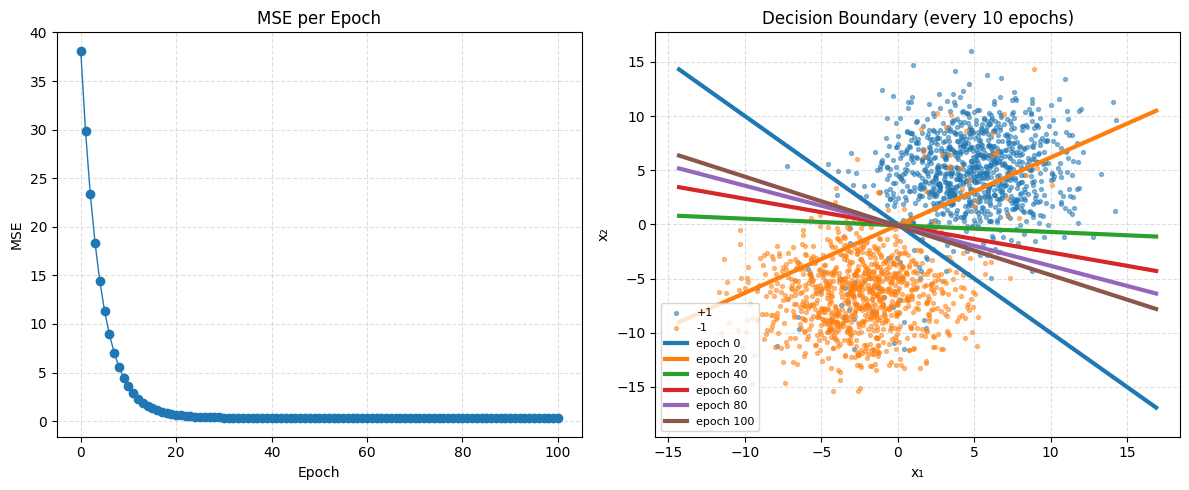

Final w: [0.04609615 0.10159487]  b: 0.013567475602030754


In [30]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(range(epochs + 1), mse_history, marker='o', linewidth=1)
ax1.set_title("MSE per Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE")
ax1.grid(True, linestyle="--", alpha=0.4)

ax2 = fig.add_subplot(1, 2, 2)


with torch.no_grad():
    X_np = X.cpu().numpy()
    y_np = y.cpu().numpy()
ax2.scatter(X_np[y_np==1, 0], X_np[y_np==1, 1], s=8, alpha=0.5, label="+1")
ax2.scatter(X_np[y_np==-1, 0], X_np[y_np==-1, 1], s=8, alpha=0.5, label="-1")


x_min, x_max = X_np[:,0].min(), X_np[:,0].max()
pad = 0.1 * (x_max - x_min)
xx = torch.linspace(x_min - pad, x_max + pad, steps=200)

def plot_decision_boundary(ax, w_t, b_t, label):
    w1, w2 = w_t[0].item(), w_t[1].item()
    if abs(w2) > 1e-8:
        yy = -(w1 / w2) * xx - (b_t / w2)
        ax.plot(xx.cpu().numpy(), yy.cpu().numpy(), linewidth=3, label=label)
    else:

        if abs(w1) > 1e-12:
            x_v = -b_t / w1
            ax.axvline(x=x_v, linewidth=2, label=label)


for ep in sorted(wb_snapshots.keys()):
    w_ep, b_ep = wb_snapshots[ep]
    plot_decision_boundary(ax2, w_ep, b_ep, label=f"epoch {ep}")

ax2.set_title("Decision Boundary (every 10 epochs)")
ax2.set_xlabel("x₁")
ax2.set_ylabel("x₂")
ax2.legend(loc="best", fontsize=8)
ax2.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

with torch.no_grad():
    y_hat_final = X @ w + b
    mse_final = torch.mean((y_hat_final - y)**2).item()
    y_pred_cls = torch.sign(y_hat_final)
    acc = (y_pred_cls == y).float().mean().item()
print("Final w:", w.cpu().numpy(), " b:", float(b))